In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import copy
import torch.nn.functional as F

In [2]:
transform = transforms.ToTensor()

train_val_dataset = datasets.FashionMNIST('.', download=True, train=True, transform=transform)
test_dataset = datasets.FashionMNIST('.', download=True, train=False, transform=transform)

In [3]:
ratio = 0.2
train_examples = int((1.0-ratio)*len(train_val_dataset))
val_examples = int(ratio*len(train_val_dataset))

In [4]:
train_dataset, val_dataset = torch.utils.data.dataset.random_split(train_val_dataset,[train_examples,val_examples])

In [5]:
batch_size = 32
epochs = 20
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [6]:
print("Train set contains %d images in %d batches" % (len(trainloader.dataset),len(trainloader)))
print("Validation set contains %d images in %d batches" % (len(valloader.dataset),len(valloader)))
print("Test set contains %d images in %d batches" % (len(testloader.dataset),len(testloader)))

Train set contains 48000 images in 1500 batches
Validation set contains 12000 images in 375 batches
Test set contains 10000 images in 313 batches


In [7]:
cuda = torch.cuda.is_available()
classes = ('tshirt','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','ankle boot')

# Classifier

In [8]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1,32,kernel_size=3)
        self.conv1_drop = nn.Dropout2d(p=0.25)
        self.conv2 = nn.Conv2d(32,64,kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=0.25)
        self.conv3 = nn.Conv2d(64,128,kernel_size=3)
        self.conv3_drop = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(128,84)
        self.fc2 = nn.Linear(84,64)
        self.fc3 = nn.Linear(64,10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1_drop(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
classifier = Classifier()
if cuda:
    classifier = classifier.cuda()
classifier

Classifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1_drop): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3_drop): Dropout2d(p=0.4, inplace=False)
  (fc1): Linear(in_features=128, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [9]:
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [10]:
training_losses = []
validation_losses = []
for epoch in range(epochs):
    current_train_loss = 0
    for images, labels in trainloader:
        if cuda:
            images, labels = images.cuda(), labels.cuda()
        output = classifier(images)
        optimizer.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item()*images.size(0)
    train_loss = current_train_loss/len(trainloader)
    training_losses.append(train_loss)
  
    classifier.eval()
    total_correct = 0
    current_val_loss = 0
    with torch.no_grad():
        for images, labels in valloader:
            if cuda:
                images, labels = images.cuda(), labels.cuda()
            output_acc = classifier(images)
            loss = criterion(output_acc,labels)
            current_val_loss += loss.item()*images.size(0)
            _, pred = torch.max(output_acc, 1)
            total_correct += torch.sum(pred==labels).item()
        val_loss = current_val_loss/len(valloader)
        validation_losses.append(val_loss)
        accuracy = total_correct / len(valloader.dataset)
    print('Epoch: {}/{} \t Training Loss: {}, Validation loss: {}, Validation Accuracy: {}'.format(epoch+1, epochs, train_loss, val_loss, accuracy))


Epoch: 1/20 	 Training Loss: 38.076410958607994, Validation loss: 20.11694401550293, Validation Accuracy: 0.7558333333333334
Epoch: 2/20 	 Training Loss: 17.343603023529052, Validation loss: 15.224545057932536, Validation Accuracy: 0.82675
Epoch: 3/20 	 Training Loss: 13.797666814009348, Validation loss: 12.703804152170816, Validation Accuracy: 0.8545833333333334
Epoch: 4/20 	 Training Loss: 12.026468021392823, Validation loss: 12.60130502319336, Validation Accuracy: 0.8510833333333333
Epoch: 5/20 	 Training Loss: 10.976796754995982, Validation loss: 10.818104706446329, Validation Accuracy: 0.8755833333333334
Epoch: 6/20 	 Training Loss: 10.055493144830068, Validation loss: 10.828448141733805, Validation Accuracy: 0.8733333333333333
Epoch: 7/20 	 Training Loss: 9.516612360159556, Validation loss: 11.136574967066448, Validation Accuracy: 0.87325
Epoch: 8/20 	 Training Loss: 8.893381668249766, Validation loss: 10.6226419506073, Validation Accuracy: 0.884
Epoch: 9/20 	 Training Loss: 8.35

Text(0, 0.5, 'Loss')

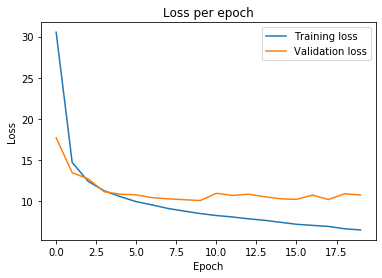

In [32]:
plt.plot(range(epochs),training_losses,label="Training loss")
plt.plot(range(epochs),validation_losses,label="Validation loss")
plt.legend()
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [36]:
class_correct = np.array([0.] * 10)
class_total = np.array([0.] * 10)
for images,labels in valloader:
    outputs = classifier(images.cuda())
    _, predicted = torch.max(outputs.cpu(), 1)
    c = (predicted == labels)
    for i in range(batch_size):
        label = labels[i].item()
        class_correct[label] += c[i].item()
        class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %f %%' % (classes[i], 100 * class_correct[i] / float(class_total[i])))

Accuracy of tshirt : 93.200663 %
Accuracy of trouser : 98.067227 %
Accuracy of pullover : 89.375507 %
Accuracy of dress : 90.909091 %
Accuracy of  coat : 77.254589 %
Accuracy of sandal : 94.803018 %
Accuracy of shirt : 50.041911 %
Accuracy of sneaker : 95.541958 %
Accuracy of   bag : 97.083333 %
Accuracy of ankle boot : 96.215307 %


In [37]:
total_correct = 0
total_loss = 0
with torch.no_grad():
    classifier.eval()
    for images, labels in testloader:
        #images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        images,labels = images.cuda(),labels.cuda()
        output_acc = classifier(images)
        loss = criterion(output_acc,labels)
        _, pred = torch.max(output_acc, 1)
        total_correct += torch.sum(pred==labels).item()
        total_loss += loss.item()*images.size(0)
    test_loss = total_loss/len(testloader)
    accuracy = total_correct / len(testloader.dataset)
print("Test loss: {}, accuracy: {}".format(test_loss,accuracy))

Test loss: 11.442269718304228, accuracy: 0.8762


# Autoencoder

In [38]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,kernel_size=2,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32,1,kernel_size=2,stride=2),
            nn.Sigmoid()
        )
  
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
auto = AutoEncoder()
if cuda:
    auto = auto.cuda()
auto

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)

In [39]:
optimizer = optim.SGD(auto.parameters(), lr=0.5, momentum=0.9)
criterion = nn.MSELoss()

In [40]:
training_losses = []
validation_losses = []
for epoch in range(epochs):
    current_train_loss = 0
    for images, labels in trainloader:
        #images = images.view(images.size()[0], -1)
        if cuda:
            images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        output = auto(images)
        loss = criterion(output, images)
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item()*images.size(0)
    train_loss = current_train_loss/len(trainloader)
    training_losses.append(train_loss)
    
    auto.eval()
    current_val_loss = 0
    with torch.no_grad():
        for images, labels in valloader:
            if cuda:
                images, labels = images.cuda(), labels.cuda()
            output = auto(images)
            loss = criterion(output,images)
            current_val_loss += loss.item()*images.size(0)
        val_loss = current_val_loss/len(valloader)
        validation_losses.append(val_loss)
    
    print('Epoch: {}/{} \t Training Loss: {} Validation Loss: {}'.format(epoch+1, epochs, train_loss,val_loss))

Epoch: 1/10 	 Training Loss: 0.4086893391807874 Validation Loss: 0.19039643426736197
Epoch: 2/10 	 Training Loss: 0.16911246170600255 Validation Loss: 0.1500594647725423
Epoch: 3/10 	 Training Loss: 0.1428517249971628 Validation Loss: 0.13354880013068518
Epoch: 4/10 	 Training Loss: 0.1288371920833985 Validation Loss: 0.12379709819952647
Epoch: 5/10 	 Training Loss: 0.12003314961989721 Validation Loss: 0.11506248792012533
Epoch: 6/10 	 Training Loss: 0.11297026162346203 Validation Loss: 0.11081832673152288
Epoch: 7/10 	 Training Loss: 0.10782733798523744 Validation Loss: 0.1097705795566241
Epoch: 8/10 	 Training Loss: 0.10356364892423153 Validation Loss: 0.10163822879393895
Epoch: 9/10 	 Training Loss: 0.10002538540959358 Validation Loss: 0.09726521564523379
Epoch: 10/10 	 Training Loss: 0.09672882513950268 Validation Loss: 0.09537966722249985


Text(0, 0.5, 'Loss')

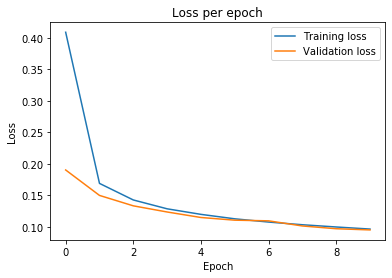

In [41]:
plt.plot(range(epochs),training_losses,label="Training loss")
plt.plot(range(epochs),validation_losses,label="Validation loss")
plt.legend()
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

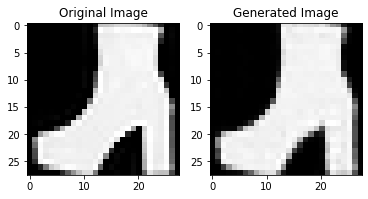

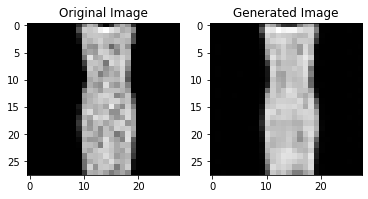

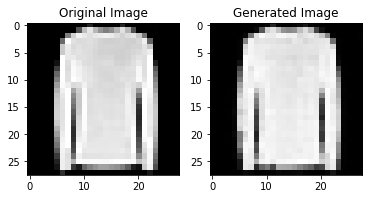

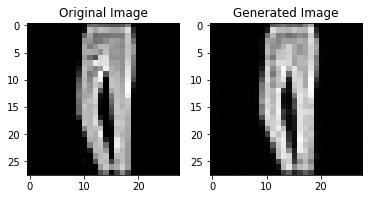

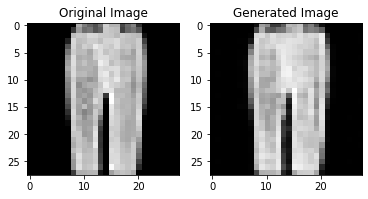

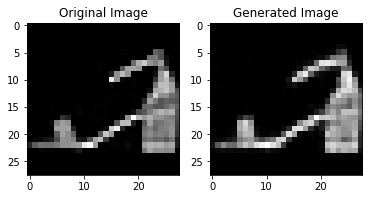

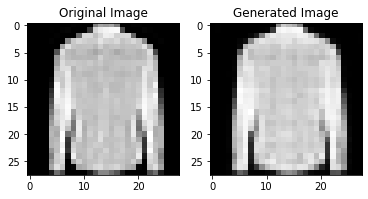

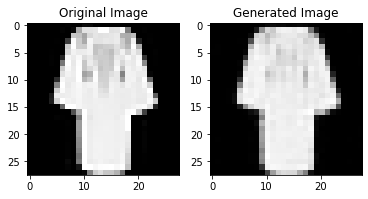

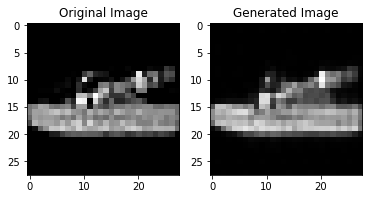

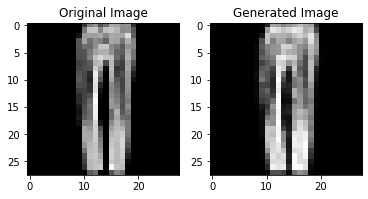

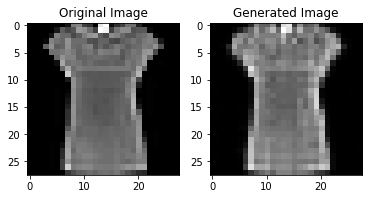

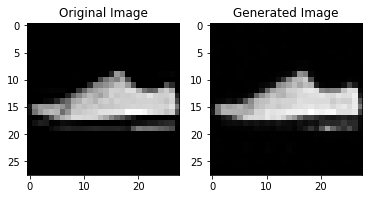

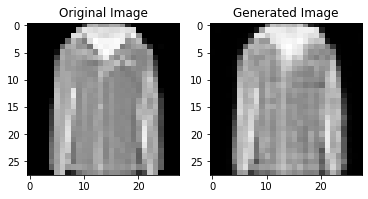

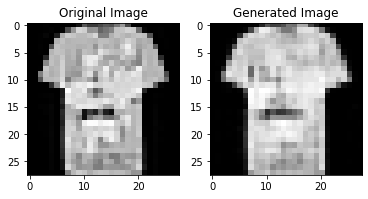

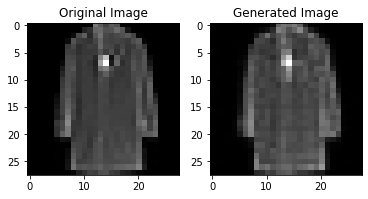

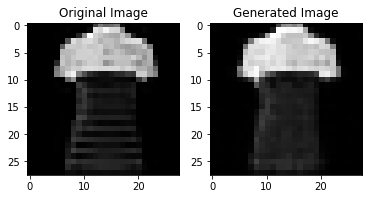

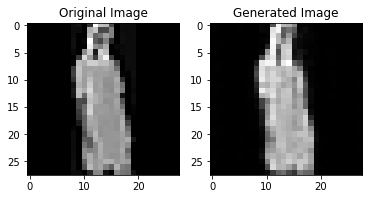

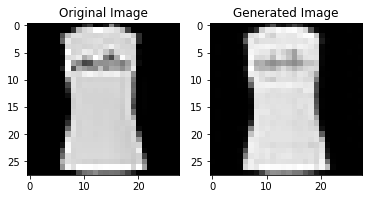

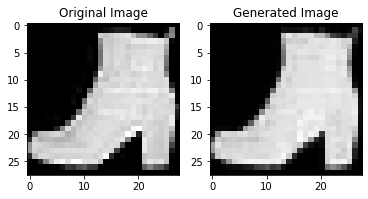

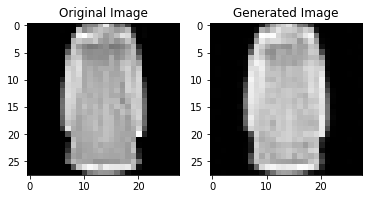

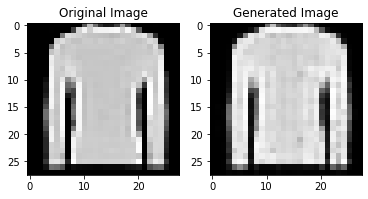

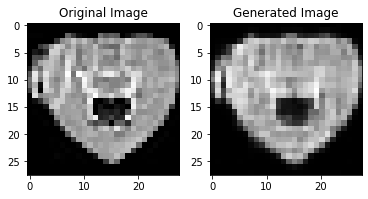

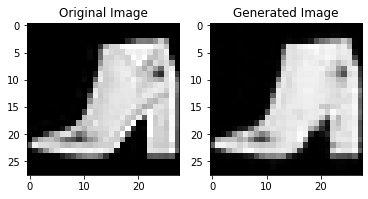

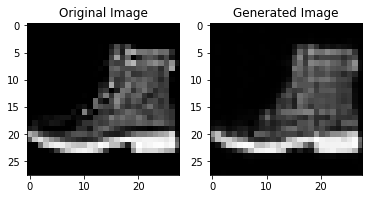

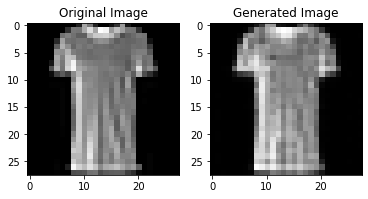

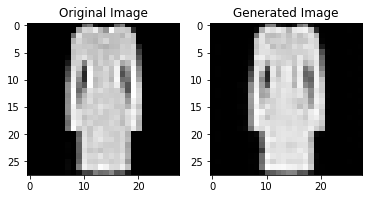

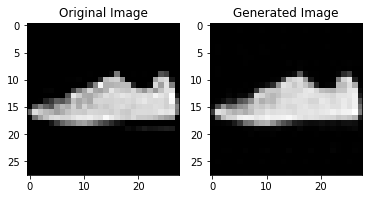

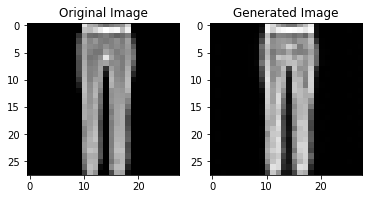

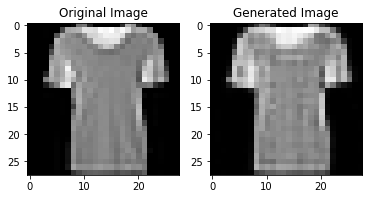

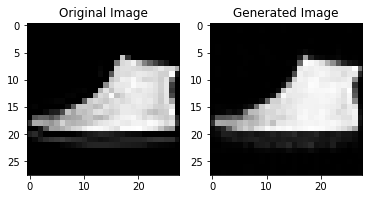

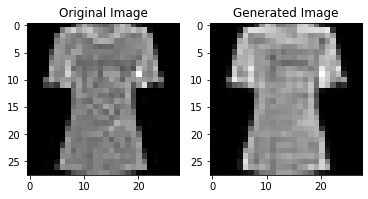

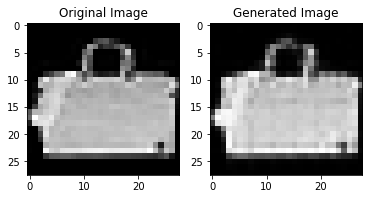

In [42]:
test_images, labels = next(iter(valloader))
#test_images = test_images.view(test_images.size()[0], -1)
if cuda:
    test_images = test_images.cuda()
test_output = auto(test_images)
  
inp = test_images.view(-1,28,28)
out = test_output.view(-1,28,28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image')
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image')
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    plt.show()

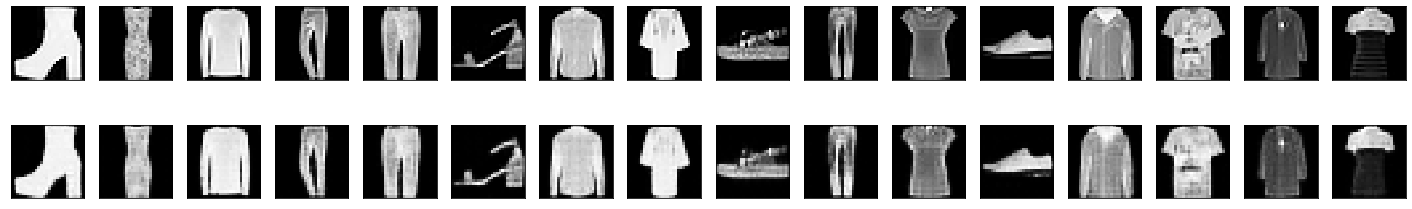

In [43]:

dataiter = iter(valloader)
images, labels = dataiter.next()
images = images.cuda()
labels = labels.cuda()

output = auto(images)                     
images = images.cpu().numpy()#
output = output.cpu()
output = output.view(batch_size, 1, 28, 28)
output = output.detach().numpy()           

fig, axes = plt.subplots(nrows=2, ncols=16, sharex=True, sharey=True, figsize=(25,4))
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [44]:
total_loss = 0
with torch.no_grad():
    classifier.eval()
    for images, labels in testloader:
        #images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        images,labels = images.cuda(),labels.cuda()
        output = auto(images)
        loss = criterion(output,images)
        total_loss += loss.item()*images.size(0)
    test_loss = total_loss/len(testloader)
print("Test loss: {}".format(test_loss))

Test loss: 0.09564189308177168


# Autoencoder + Classifier Combined Model (two losses)

In [13]:
class Mixed(nn.Module):
    def __init__(self):
        super(Mixed, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.25),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.25),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,kernel_size=2,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32,1,kernel_size=2,stride=2),
            nn.Sigmoid()
        )
        self.classifier = nn.Sequential(
            nn.Linear(3136,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,10)
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        encoded = encoded.view(encoded.size(0),-1)
        predicted = self.classifier(encoded)
        return decoded, predicted
net3 = Mixed()
net3 = net3.cuda()
net3

Mixed(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.25, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Dropout2d(p=0.25, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
  (classifier): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [14]:
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
optimizer = optim.SGD(net3.parameters(), lr=0.01, momentum=0.9)

In [16]:
training_losses = []
validation_losses = []
for epoch in range(epochs):
    current_train_loss = 0
  
    for images, labels in trainloader:
        
        images, labels = images.cuda(),labels.cuda()
        #images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        decoded, predicted = net3(images)
        loss1 = criterion1(decoded,images)
        loss2 = criterion2(predicted, labels)
        loss = loss1+loss2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item()*images.size(0)
    train_loss = current_train_loss/len(trainloader)
    training_losses.append(train_loss)

    net3.eval()
    total_correct = 0
    current_val_loss = 0
    with torch.no_grad():
        for images, labels in valloader:
            #images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
            images, labels = images.cuda(),labels.cuda()
            decoded, output_acc = net3(images)
            val_loss1 = criterion1(decoded,images)
            val_loss2 = criterion2(output_acc, labels)
            total_val_loss = val_loss1+val_loss2
            _, pred = torch.max(output_acc, 1)
            total_correct += torch.sum(pred==labels).item()
            current_val_loss += total_val_loss.item()*images.size(0)
        val_loss = current_val_loss/len(valloader)
        validation_losses.append(val_loss)
        accuracy = total_correct / len(valloader.dataset)
    print('Epoch: {}/{} \t Training Loss: {}, Validation loss: {}, Validation Accuracy: {}'.format(epoch+1, epochs, train_loss, val_loss, accuracy))

Epoch: 1/10 	 Training Loss: 19.48174849541982, Validation loss: 14.32509189860026, Validation Accuracy: 0.8480833333333333
Epoch: 2/10 	 Training Loss: 12.232602337678273, Validation loss: 11.420307581583659, Validation Accuracy: 0.8758333333333334
Epoch: 3/10 	 Training Loss: 10.17951916495959, Validation loss: 10.38547735786438, Validation Accuracy: 0.8871666666666667
Epoch: 4/10 	 Training Loss: 9.028695135593415, Validation loss: 9.420961718241374, Validation Accuracy: 0.90125
Epoch: 5/10 	 Training Loss: 8.15939976112048, Validation loss: 8.993782260258993, Validation Accuracy: 0.9051666666666667
Epoch: 6/10 	 Training Loss: 7.419138706127803, Validation loss: 8.697056442896525, Validation Accuracy: 0.9073333333333333
Epoch: 7/10 	 Training Loss: 6.885822461764017, Validation loss: 8.221917022387187, Validation Accuracy: 0.9135833333333333
Epoch: 8/10 	 Training Loss: 6.392323883891105, Validation loss: 8.288362609227498, Validation Accuracy: 0.9140833333333334
Epoch: 9/10 	 Trai

Text(0, 0.5, 'Loss')

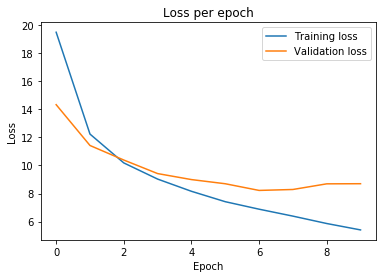

In [17]:
plt.plot(range(epochs),training_losses,label="Training loss")
plt.plot(range(epochs),validation_losses,label="Validation loss")
plt.legend()
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

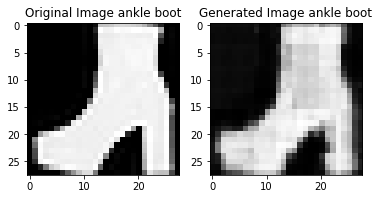

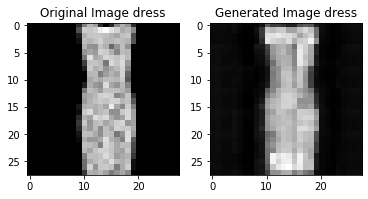

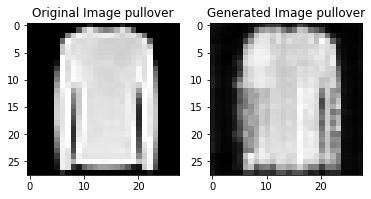

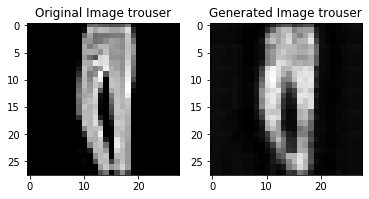

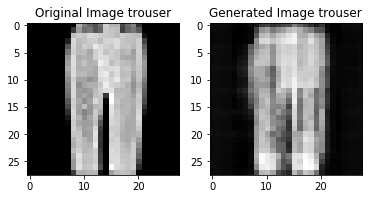

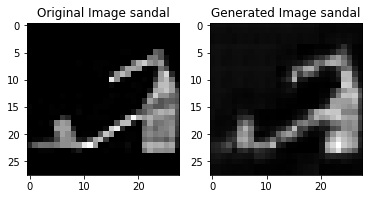

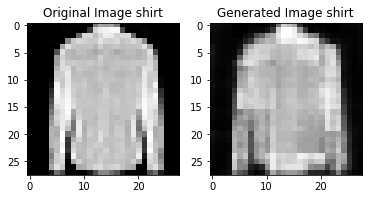

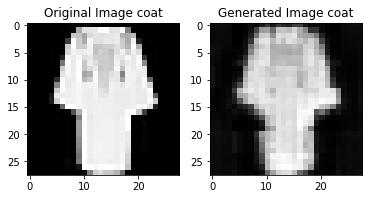

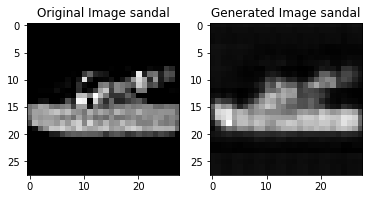

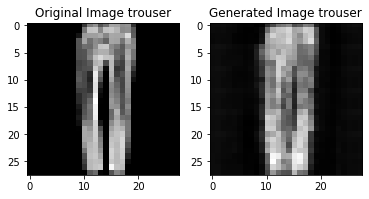

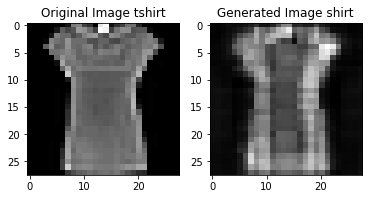

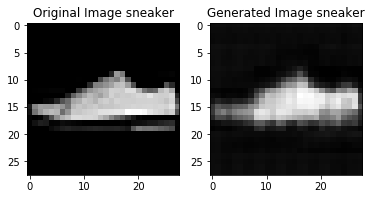

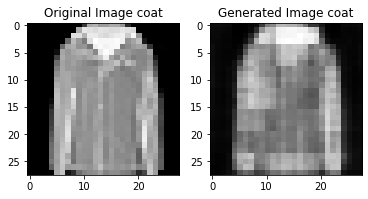

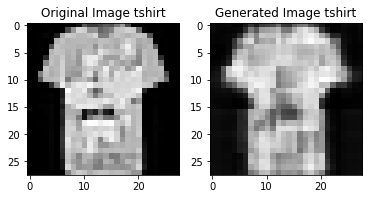

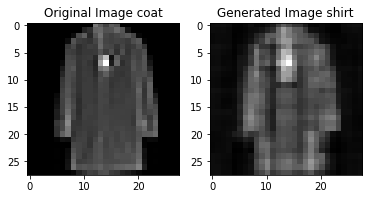

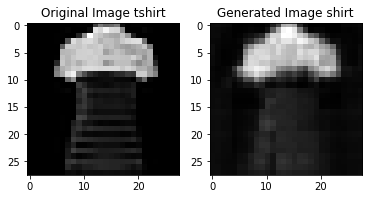

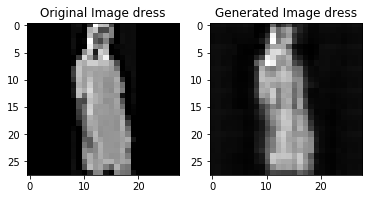

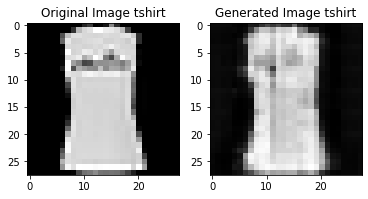

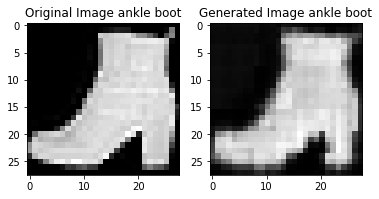

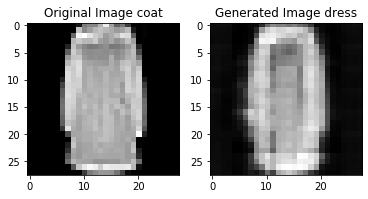

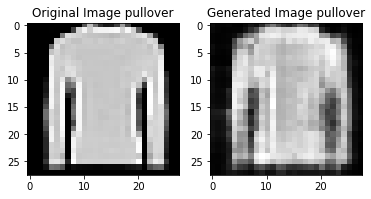

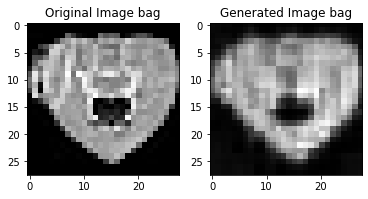

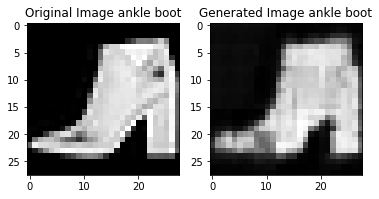

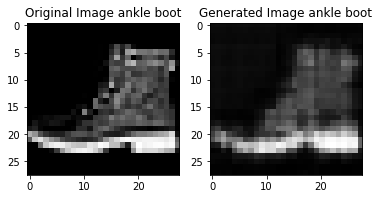

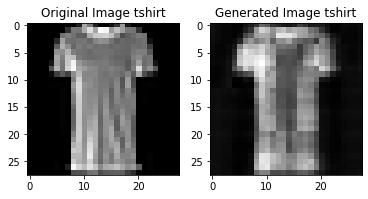

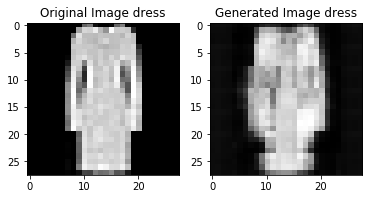

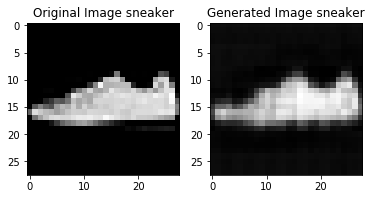

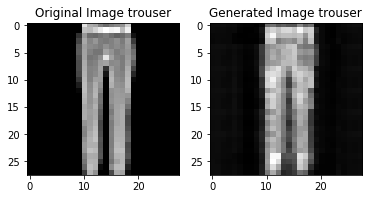

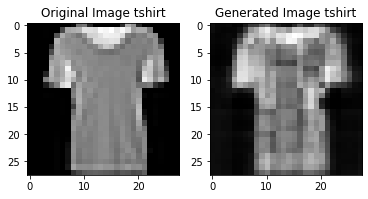

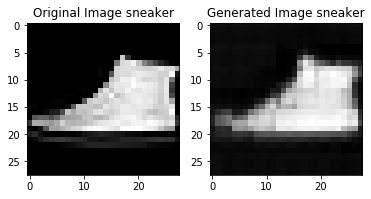

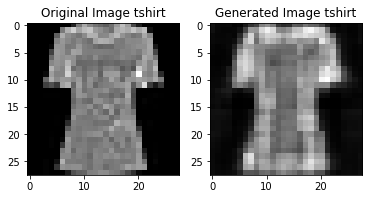

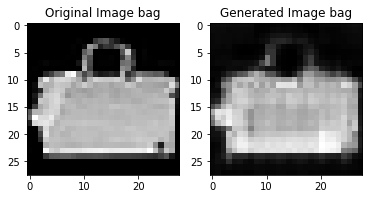

In [49]:
test_images, labels = next(iter(valloader))

#test_images = test_images.view(test_images.size()[0], -1).cuda()
test_images, labels = test_images.cuda(),labels.cuda()
test_output, predicted = net3(test_images)
_, predicted_label = torch.max(predicted, 1)
  
inp = test_images.view(-1, 28, 28)
out = test_output.view(-1, 28, 28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    #print("Ground truth", classes[labels[i]])
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image ' + str(classes[predicted_label[i]]))
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    #print("Predicted", classes[predicted_label[i]])
    plt.show()

In [50]:
class_correct = np.array([0.] * 10)
class_total = np.array([0.] * 10)
for images,labels in valloader:
    #decoded, outputs = net3(Variable(images.view(-1, 28*28).cuda()))
    decoded, outputs = net3(images.cuda())
    _, predicted = torch.max(outputs.cpu(), 1)
    c = (predicted == labels)
    for i in range(batch_size):
        label = labels[i].item()
        class_correct[label] += c[i].item()
        class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %f %%' % (classes[i], 100 * class_correct[i] / float(class_total[i])))

Accuracy of tshirt : 79.519071 %
Accuracy of trouser : 98.823529 %
Accuracy of pullover : 85.320357 %
Accuracy of dress : 89.658048 %
Accuracy of  coat : 89.624900 %
Accuracy of sandal : 98.826488 %
Accuracy of shirt : 78.960604 %
Accuracy of sneaker : 94.143357 %
Accuracy of   bag : 99.083333 %
Accuracy of ankle boot : 97.897393 %


In [52]:
total_correct = 0
total_loss = 0
with torch.no_grad():
    net3.eval()
    for images, labels in testloader:
        #images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        images,labels = images.cuda(),labels.cuda()
        decoded, output_acc = net3(images)
        test_loss1 = criterion1(decoded,images)
        test_loss2 = criterion2(output_acc, labels)
        test_loss = test_loss1+test_loss2
        _, pred = torch.max(output_acc, 1)
        total_correct += torch.sum(pred==labels).item()
        total_loss += test_loss.item()*images.size(0)
    final_loss = total_loss/len(testloader)
    accuracy = total_correct / len(testloader.dataset)
print("Test loss: {}, accuracy: {}".format(final_loss,accuracy))

Test loss: 8.742660267665363, accuracy: 0.9074


# Cells currently not in use

In [9]:
# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x
auto = Autoencoder()
if cuda:
    auto = auto.cuda()
auto

Autoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)

In [ ]:
#NOT IN USE
correct = 0
total = 0
with torch.no_grad():
    for images,labels in testloader:
        images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        decoded, output_acc = net(images)
        _, predicted = torch.max(output_acc, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network: %.3f %%' % (
    100 * correct / total))

In [ ]:
#NOT CURRENTLY IN USE - TRAINING THE AUTOENCODER BY ITSELF
epochs = 5
for epoch in range(epochs):
    runningloss = 0
  
    for images, labels in trainloader:
        images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, images.view(images.size()[0], -1))
        loss.backward()
        optimizer.step()
        runningloss += loss.item()/images.shape[0]
    print('Epoch: {}/{} \t Mean Square Error Loss: {}'.format(epoch+1, epochs, runningloss))

In [8]:
# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(32, 1, 2, stride=2)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x
auto = Autoencoder()
if cuda:
    auto = auto.cuda()
auto

Autoencoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
)

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
classifier = Classifier()
if cuda:
    classifier = classifier.cuda()
classifier


In [ ]:
epochs = 5
for epoch in range(epochs):
    runningloss = 0
  
    for images, labels in testloader:
        images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        output = net(images)
        #print(images.shape) #16x784
        #print(labels.shape) #16
        #print(output.shape) #16x10
        optimizer.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        runningloss += loss.item()/images.shape[0]
  

    net.eval()
    total_correct = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
            output_acc = net(images)
            _, pred = torch.max(output_acc, 1)
            total_correct += torch.sum(pred==labels).item()
        accuracy = total_correct / len(testloader.dataset)
    print('Epoch: {}/{} \t Training Loss: {}, Test Accuracy: {}'.format(epoch, epochs, runningloss, accuracy))

